# Packages


In [153]:
# scikit-learn pereptron and adaline implementations
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from itertools import combinations

# Preprocess the data

In [154]:
data = pd.read_csv('project_adult.csv')
validation = pd.read_csv('project_validation_inputs.csv')
print(data.head())

   Unnamed: 0  age         workclass  fnlwgt     education  education-num  \
0        5514   33         Local-gov  198183     Bachelors             13   
1       19777   36           Private   86459     Assoc-voc             11   
2       10781   58  Self-emp-not-inc  203039           9th              5   
3       32240   21           Private  180190     Assoc-voc             11   
4        9876   27           Private  279872  Some-college             10   

       marital-status       occupation   relationship   race     sex  \
0       Never-married   Prof-specialty  Not-in-family  White  Female   
1  Married-civ-spouse  Exec-managerial        Husband  White    Male   
2           Separated     Craft-repair  Not-in-family  White    Male   
3  Married-civ-spouse  Farming-fishing        Husband  White    Male   
4            Divorced    Other-service  Not-in-family  White    Male   

   capital-gain  capital-loss  hours-per-week native-country income  
0             0             0     

In [155]:
# from google.colab import drive
# drive.mount('/content/drive')

In [156]:
# Function to preprocess data
def preprocess_data(df):
    # Take out educational since is ordinal, ordinal var is already in dataset
    df = df.drop(columns = ['Unnamed: 0', 'education'])
    # Handle missing values
    df = df.dropna()
    # Replace all values unknown with most common ('Private')
    df['workclass'] = df['workclass'].apply(lambda x: df['workclass'].value_counts().index[0] if x == '?' else x)

    # TRY EXCEPT SO VALIDATION SET CAN PASS
    # Binarize the target variable
    try:
        df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)
    except:
        pass

    # keep track of rows indexes to connect X and y
    df = df.reset_index()

    # Deal with Categorical Values

    # initialize encoder
    encoder = OneHotEncoder(sparse_output=False)
    # pull categorical cols
    categorical_cols = df.select_dtypes(include='object').columns
    # create encoded array w one hot columns
    encoded_array = encoder.fit_transform(df[categorical_cols])
    # Get new column names
    encoded_cols = encoder.get_feature_names_out(categorical_cols)
    # Creae new df of encoded columns
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)
    # Drop the original cat cols, add the one hot encoded one
    df = df.drop(categorical_cols, axis=1)
    df = pd.concat([df, encoded_df], axis=1)
    df = df.drop('index', axis = 1)

    # Ensure all columns are numeric after one-hot encoding
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # TRY EXCEPTS SO THE VALIDATION SET CAN PASS WITH NO Y VARIABLE
    # Separate features and target
    try:
        X = df.drop(columns=['income'], axis=1)
    except:
        X = df
    try:
        y = df['income']
    except:
        y = None

    # Standardize numerical features
    numeric_cols = ['age','fnlwgt','capital-gain','capital-loss', 'hours-per-week']
    scaler = StandardScaler()
    # Ensure numeric columns exist before scaling
    numeric_cols_exist = [col for col in numeric_cols if col in X.columns]
    if numeric_cols_exist:
        X[numeric_cols_exist] = scaler.fit_transform(X[numeric_cols_exist])


    return X, y

In [157]:
X, y = preprocess_data(data)
X_validation, _ = preprocess_data(validation)
missing_cols = [
    'native-country_Holand-Netherlands',
    'native-country_Outlying-US(Guam-USVI-etc)',
    'workclass_Never-worked'
]

for col in missing_cols:
    X_validation[col] = 0
X_validation = X_validation.reindex(columns=X.columns, fill_value=0)

# Split the data 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)


# Perception & Adaline SciKit


In [158]:
# Assumption:  This code assumes you have already clean, processed, and split a data set.
'''
Input Data Required:
X_train = cleaned, processed input data for training prediction models
y_train = response variable associated with X_train; truth values
X_test = cleaned, processed input data for testing prediction model created on training dataset
y_test = response variable associated with X_test; truth values

Note: Current order of rows ensure y_train = X_train and y_test = X_test, but if you sort and remove rows this association changes.
'''
# Re - preprocess the validation set to match columns/data removed from original preprocess step
X_validation, _ = preprocess_data(validation)

# Realign the validation columns to be ordered in same way as test (Used ChatGPT to help me do this because I was getting error)
X_validation = X_validation.reindex(columns=X.columns, fill_value=0)

# Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.1, max_iter=15, random_state=42)
sk_ppn.fit(X_train, y_train)
sk_y_pred_ppn = sk_ppn.predict(X_test)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(y_test, sk_y_pred_ppn):.4f}")

# The validations predictions for perceptron and print the resulting file
sk_validation_pred_ppn = sk_ppn.predict(X_validation)
pd.DataFrame(sk_validation_pred_ppn).to_csv("Group_9_Perceptron_PredictedOutputs.csv", index=False, header=False)

# Scikit-learn Adaline (using SGDClassifier with 'log_loss' is closer, but 'perceptron' is available)
# For Adaline (which uses GD), SGDClassifier with 'hinge' loss is a good proxy, as it's a linear classifier with regularization
sk_ada = SGDClassifier(loss="perceptron", eta0=0.0001, learning_rate="constant",max_iter=15, random_state=42)
sk_ada.fit(X_train, y_train)
sk_y_pred_ada = sk_ada.predict(X_test)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test, sk_y_pred_ada):.4f}")

Scikit-learn Perceptron accuracy: 0.8432
Scikit-learn Adaline (SGDClassifier) accuracy: 0.8073


# Perceptron

Perceptron code class from in class assignment.

In [159]:
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        # Ensure X and y are NumPy arrays and numeric
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)

        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        # Explicitly convert X to a NumPy array with float64 dtype
        return np.dot(np.asarray(X, dtype=np.float64), self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

Actually implementing the model here. Understand the learning rate of the model and its misclassifications.

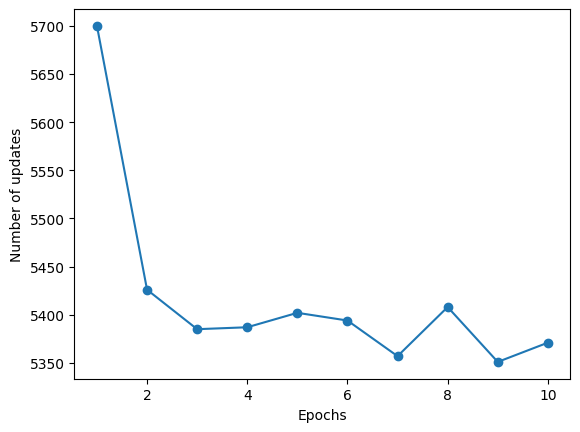

In [160]:
# ### Training the perceptron model
ppn = Perceptron(eta=0.1, n_iter=10, random_state=1)
ppn.fit(X.to_numpy(dtype=np.float64), y.to_numpy())

# Plot miscalssificaiotn error for each epoch
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

We had many issues with our Perceptron manual accuracy being too high. We knew that we could achieve an accuracy higher than scikit but we kept running the model and got accuracies hovering around 85% accuracy with minimal parameter tuning. After this we did some research and changed the code we were provided in class to account for this. We used the book and ChatGPT to help edit the code and account for some of the possibility that the model was just getting lucky on the training data. We found that by testing the pre processed data on different seeds over our parameter boundary would help us to visualize the accuracies and understand what was just luck and what was actually consistently getting the results correct. So we used a for loop to test 5 different seeds and also re shuffle the data every time manually using the help of ChatGPT. After this we just implemented the code from the book to predict the results on our test data and to see its results. This resulted in what we expected, a wide variety of accuracies across different runs. So we then took the averages of each combination of parameters to better understand what was consistent and to decide which model was our most optimal for manual perceptron.

In [161]:
# create empty result list and create parameters to test
results = []
seeds = [1, 2, 3, 4, 5]
list_eta = [.0001,0.001, 0.01, 0.05, 0.1]
list_niter = [5, 10, 15, 20, 30]

# Test Manual Perceptron Model with shuffling and random seeds
# Loop through each seed, n_iter, and eta combination
for seed in seeds:
    print(f"\nRandom State: {seed}")
    for n_temp in list_niter:
        for e_temp in list_eta:
            # Shuffle training data again because of shuffling issues from before
            # Used ChatGPT to help me with this section of extra shuffling because I kept on getting higher than usual accuracies and wanted to make sure it was shuffled fully
            X_train_shuffle = X_train.to_numpy(dtype=np.float64).copy()
            y_train_shuffle = y_train.to_numpy().copy()
            rng = np.random.RandomState(seed)  
            indices = np.arange(X_train_shuffle.shape[0])
            rng.shuffle(indices)
            X_train_shuffle, y_train_shuffle = X_train_shuffle[indices], y_train_shuffle[indices]

            # Train manual perceptron
            ppn = Perceptron(eta=e_temp, n_iter=n_temp, random_state=seed)
            ppn.fit(X_train_shuffle, y_train_shuffle)

            # Predict on test set
            y_pred = ppn.predict(X_test.to_numpy(dtype=np.float64))
            acc = (y_pred == y_test.to_numpy()).mean()

            print(f"eta={e_temp}, n_iter={n_temp} --> Test Accuracy: {acc:.4f}")

            # Store results
            results.append({"seed": seed, "eta": e_temp,"n_iter": n_temp,"accuracy": acc})
            

# CTurn results into datframe
df_results = pd.DataFrame(results)
# take the average across seeds for each (eta, n_iter)
avg_results = (df_results.groupby(["eta", "n_iter"])["accuracy"].mean().reset_index())
# Sort 
avg_results = avg_results.sort_values(by="accuracy", ascending=False)
# Print results
print("\nAverage accuracies across all seeds: \n")
print(avg_results.to_string(index=False))


Random State: 1
eta=0.0001, n_iter=5 --> Test Accuracy: 0.7885
eta=0.001, n_iter=5 --> Test Accuracy: 0.7906
eta=0.01, n_iter=5 --> Test Accuracy: 0.7883
eta=0.05, n_iter=5 --> Test Accuracy: 0.8430
eta=0.1, n_iter=5 --> Test Accuracy: 0.8453
eta=0.0001, n_iter=10 --> Test Accuracy: 0.7935
eta=0.001, n_iter=10 --> Test Accuracy: 0.7829
eta=0.01, n_iter=10 --> Test Accuracy: 0.7942
eta=0.05, n_iter=10 --> Test Accuracy: 0.7912
eta=0.1, n_iter=10 --> Test Accuracy: 0.8491
eta=0.0001, n_iter=15 --> Test Accuracy: 0.8438
eta=0.001, n_iter=15 --> Test Accuracy: 0.7860
eta=0.01, n_iter=15 --> Test Accuracy: 0.7935
eta=0.05, n_iter=15 --> Test Accuracy: 0.7908
eta=0.1, n_iter=15 --> Test Accuracy: 0.7983
eta=0.0001, n_iter=20 --> Test Accuracy: 0.8468
eta=0.001, n_iter=20 --> Test Accuracy: 0.8441
eta=0.01, n_iter=20 --> Test Accuracy: 0.8464
eta=0.05, n_iter=20 --> Test Accuracy: 0.7925
eta=0.1, n_iter=20 --> Test Accuracy: 0.7954
eta=0.0001, n_iter=30 --> Test Accuracy: 0.7827
eta=0.001, n

We analyzed the averages and took the combination of: ETA: .001 and Iterations: 30 . For this project we are going to say that using a learning rate of .001 and iterations of 30 on seed 4 is the most accurate. With the caveat that we can see its performance varies across different shuffles and seeds. So we would still lean on using the scikit learn perceptron model for optimal cross validation, performance, and consistency. If we were to test this on new data we believe that over time sticking with scikit learn perceptron will lead to the most stable and optimal performances so we decided to use that as our validation test. Some combinations had one offs of high performance but we wanted to pick the model that remained the most stable and had the highest average of success and that would be an accuracy of .8466 on seed 4.

Take the same parameter combinations and visualize the epochs and learning rate for each combination of our chosen parameters.

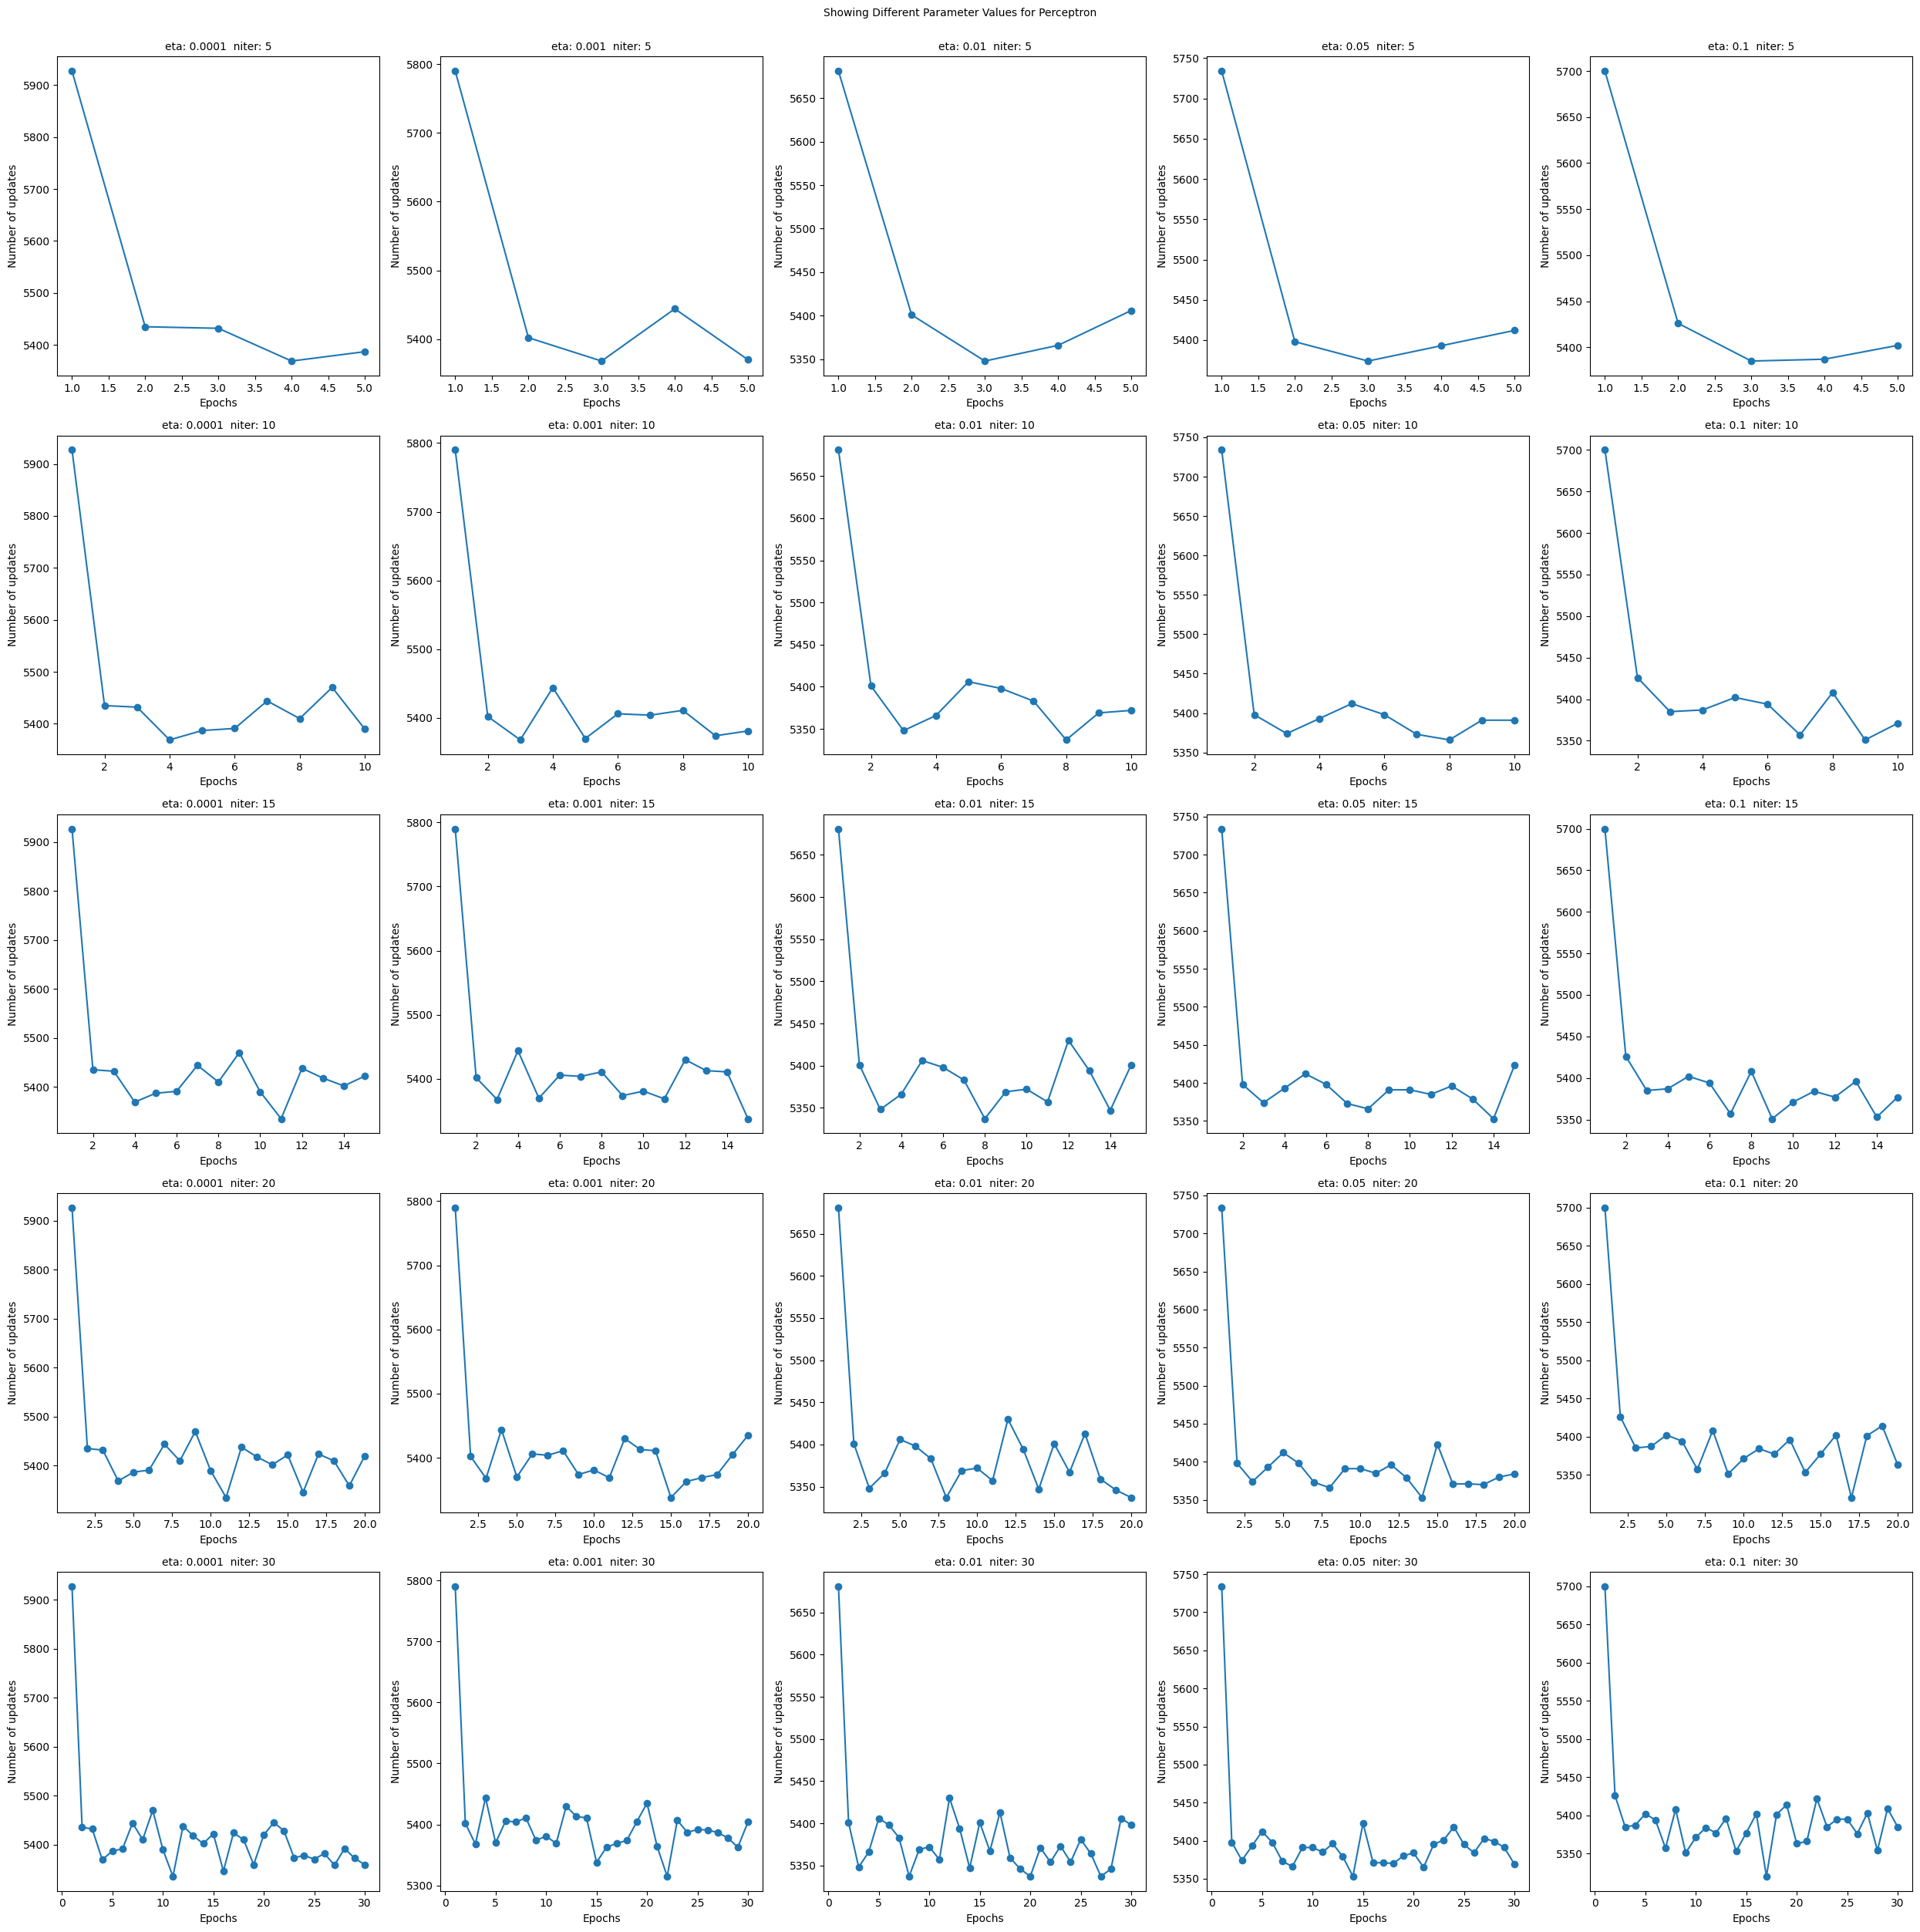

In [162]:
# Train Perceptron and find good value of eta and n_iter
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
list_eta = [0.0001, 0.001, 0.01, 0.05, .1]
list_niter = [5, 10, 15, 20, 30]
fig.suptitle("Showing Different Parameter Values for Perceptron", fontsize=10, y=1)

for j, n_temp in enumerate(list_niter):
    for i, e_temp in enumerate(list_eta):
        ppn = Perceptron(n_iter=n_temp, eta= e_temp).fit(X, y)
        ax[j, i].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Number of updates', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)

plt.tight_layout()
plt.show()

# AdlineGD


Start with AdlineGD then compare to AdlineSGD.

In [163]:
class AdalineGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared eror loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,
            # in the case of logistic regression (as we will see later),
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

Visualize the learning differences between a wide gap of learning rates to understand how it affects MSE. Here we test .1 vs .0001.

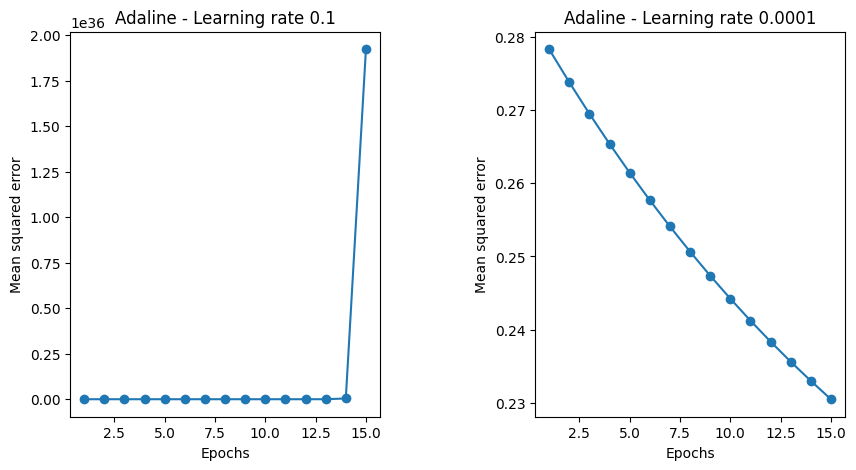

In [164]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ada1 = AdalineGD(n_iter=15, eta=0.1, random_state=1).fit(
    X_train, y_train
)
ax[0].plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Mean squared error')
ax[0].set_title('Adaline - Learning rate 0.1')

ada2 = AdalineGD(n_iter=15, eta=0.0001, random_state=1).fit(
    X_train, y_train
)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.subplots_adjust(wspace=0.5)
plt.show()

Clearly the slower learning rate at .0001 improves its MSE at a much more stable rate, though it takes much longer to get to the minimum. Probably want something more in the middle.

Test learning rates at values in between, at .05, .01, and .001.

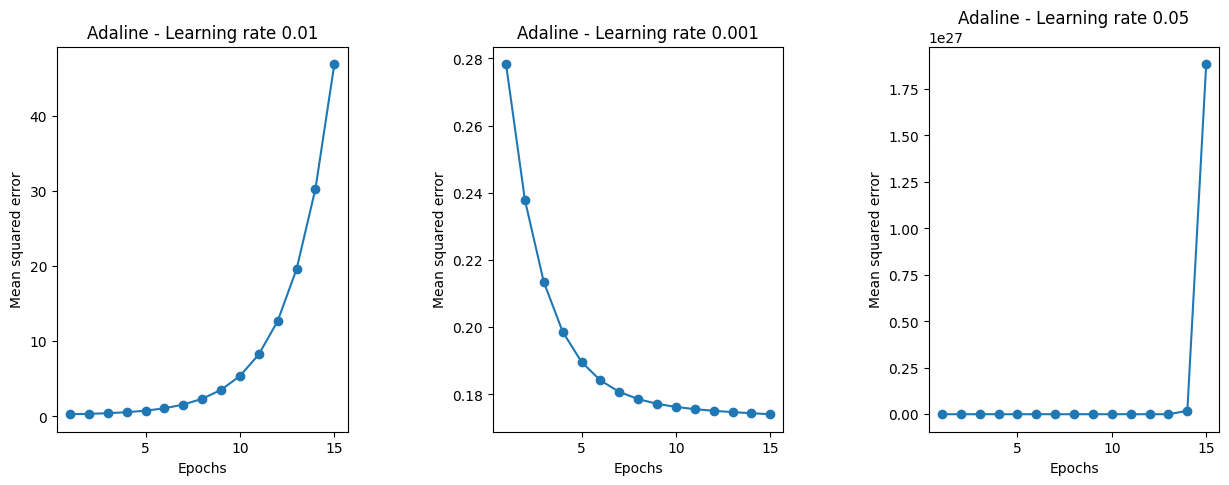

In [165]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ada3 = AdalineGD(n_iter=15, eta=0.01, random_state=1).fit(
    X_train, y_train
)
ax[0].plot(range(1, len(ada3.losses_) + 1), ada3.losses_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Mean squared error')
ax[0].set_title('Adaline - Learning rate 0.01')

ada4 = AdalineGD(n_iter=15, eta=0.001, random_state=1).fit(
    X_train, y_train
)
ax[1].plot(range(1, len(ada4.losses_) + 1), ada4.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.001')


ada5 = AdalineGD(n_iter=15, eta=0.05, random_state=1).fit(
    X_train, y_train
)
ax[2].plot(range(1, len(ada5.losses_) + 1), ada5.losses_, marker='o')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Mean squared error')
ax[2].set_title('Adaline - Learning rate 0.05')

plt.subplots_adjust(wspace=0.5)
plt.show()

The .01 and .05 learnng rate seems to be getting worse over more iterations, so .001 learning rate seems like the best option for converging to its minimum at the most efficient rate.

Now we can visualize the parameter combinations and understand their accuracies across all parameter combinations.

Adaline accuracy with n_iter 5 and eta 0.1: 0.2440
Adaline accuracy with n_iter 5 and eta 0.05: 0.2440
Adaline accuracy with n_iter 5 and eta 0.01: 0.2664
Adaline accuracy with n_iter 5 and eta 0.001: 0.7560
Adaline accuracy with n_iter 5 and eta 0.0001: 0.7560
Adaline accuracy with n_iter 10 and eta 0.1: 0.7560
Adaline accuracy with n_iter 10 and eta 0.05: 0.7560
Adaline accuracy with n_iter 10 and eta 0.01: 0.7560
Adaline accuracy with n_iter 10 and eta 0.001: 0.7560
Adaline accuracy with n_iter 10 and eta 0.0001: 0.7560
Adaline accuracy with n_iter 15 and eta 0.1: 0.2440
Adaline accuracy with n_iter 15 and eta 0.05: 0.2440
Adaline accuracy with n_iter 15 and eta 0.01: 0.2440
Adaline accuracy with n_iter 15 and eta 0.001: 0.7560
Adaline accuracy with n_iter 15 and eta 0.0001: 0.7560
Adaline accuracy with n_iter 20 and eta 0.1: 0.7560
Adaline accuracy with n_iter 20 and eta 0.05: 0.7560
Adaline accuracy with n_iter 20 and eta 0.01: 0.7560
Adaline accuracy with n_iter 20 and eta 0.001:

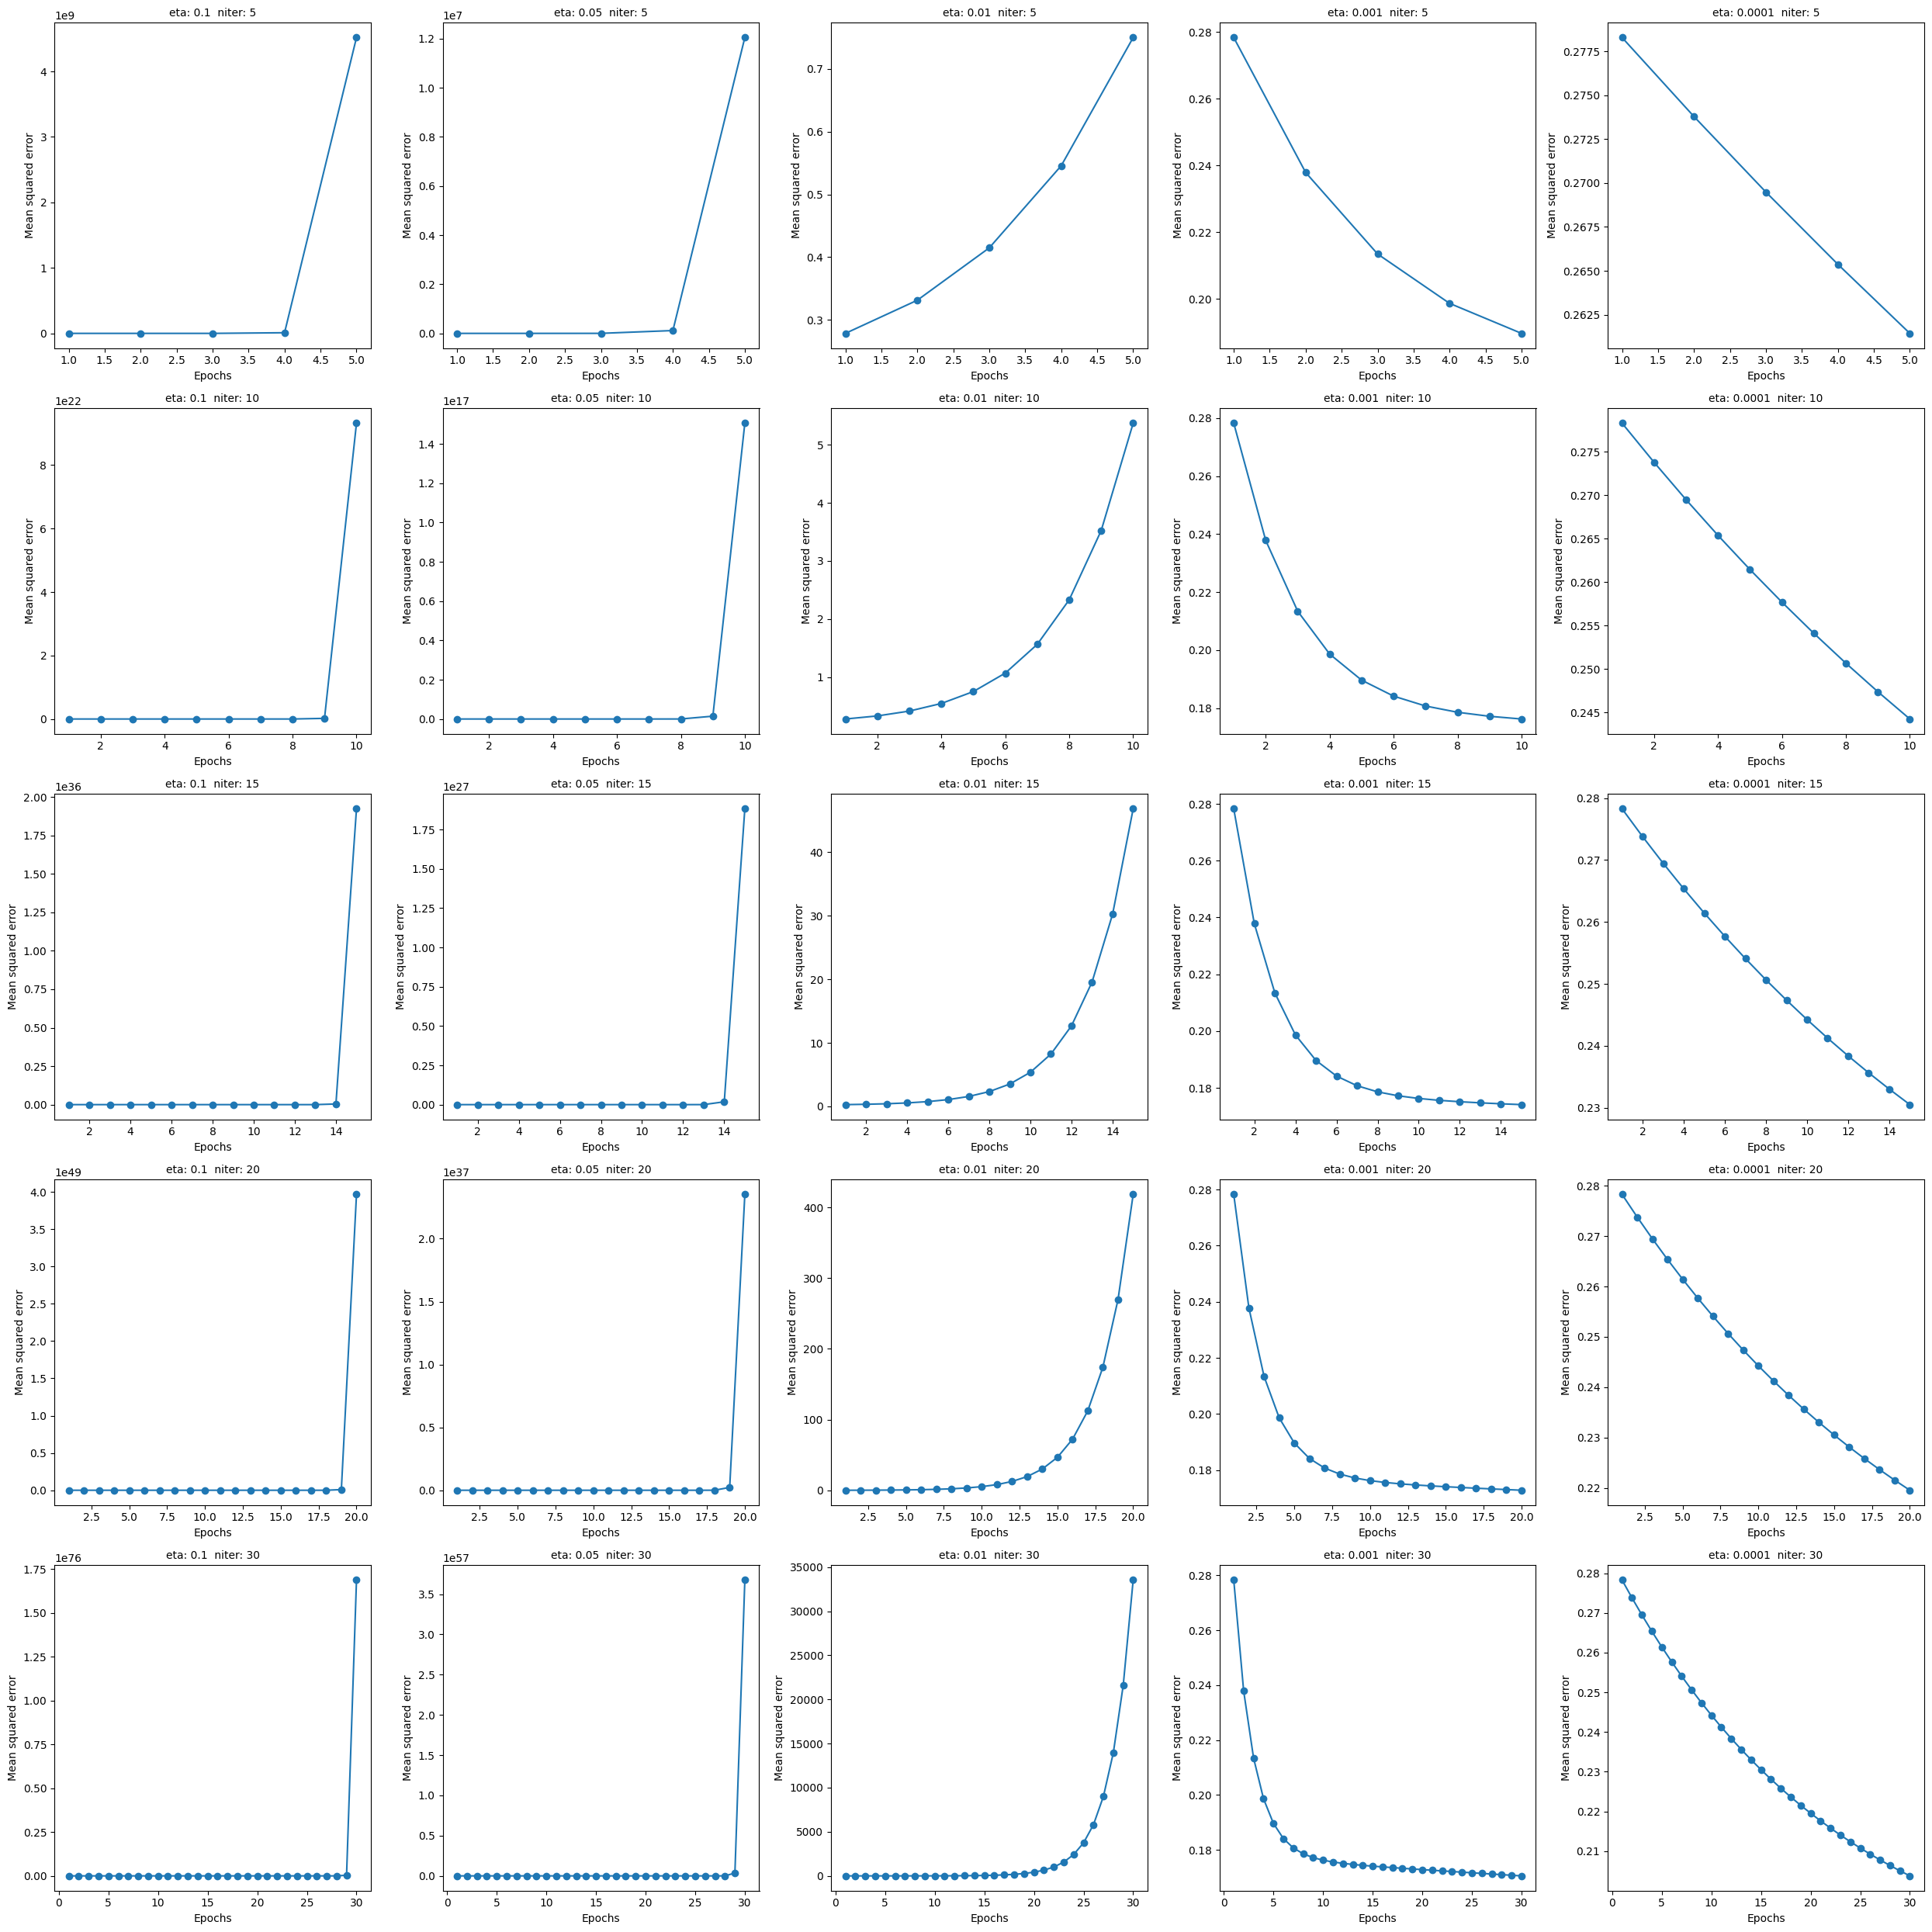

In [166]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
list_eta = [0.1, 0.05, 0.01, 0.001, 0.0001]
list_niter = [5, 10, 15, 20, 30]

for j, n_temp in enumerate(list_niter):
    for i, e_temp in enumerate(list_eta):
        ada = AdalineGD(n_iter=n_temp, eta=e_temp, random_state=1).fit(
            X_train, y_train
        )
        ax[j, i].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Mean squared error', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)

        y_pred = ada.predict(X_test)
        print(f"Adaline accuracy with n_iter {n_temp} and eta {e_temp}: {accuracy_score(y_test, y_pred):.4f}")

plt.tight_layout()
plt.show()

We believe that this shows that AdalineGD is not the most optimal model for this data. We can see how it struggles in accuracy and needs a learning rate above .001 to actually improve its plotting. After this learning rate as well it is hard to see an actual increase in correct predictions. Since all of the accuracies are the same we can choose any model and just focus on what takes the least computing power so we will say iterations of 5 and learning rate of .001 is the most optimal model for AdalineGD at .7560 though we do not recommend it, probably because the AdalineGD is restricted to just a singular linear boundary which is not sufficient enough for this data, as well as the lack of optimizers available in the other models.

# AdalineSGD


Compare how AdlineGD compares to AdlineSGD.

In [167]:
class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.


    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

First understand the effects of learning rates with no shuffling.

We quickly realized the MSE would not plot unless we had a learning rate of .001 or lower which we found interesting.

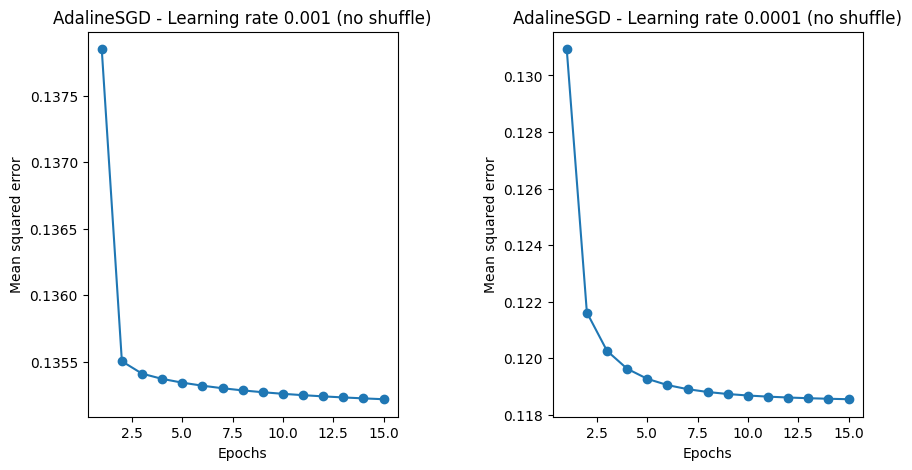

In [168]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ada1 = AdalineSGD(n_iter=15, eta=0.001, shuffle=False, random_state=1).fit(
    X_train.values, y_train.values
)
ax[0].plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Mean squared error')
ax[0].set_title('AdalineSGD - Learning rate 0.001 (no shuffle)')

ada2 = AdalineSGD(n_iter=15, eta=0.0001, shuffle=False, random_state=1).fit(
    X_train.values, y_train.values
)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('AdalineSGD - Learning rate 0.0001 (no shuffle)')


plt.subplots_adjust(wspace=0.5)
plt.show()

Understand the accuracies associated with these runs.

In [169]:
y_pred = ada1.predict(X_test.values)
print(f"AdalineSGD accuracy with n_iter 15 and eta 0.001 (no shuffle): {accuracy_score(y_test, y_pred):.4f}")

y_pred = ada2.predict(X_test.values)
print(f"AdalineSGD accuracy with n_iter 15 and eta 0.0001 (no shuffle): {accuracy_score(y_test, y_pred):.4f}")


AdalineSGD accuracy with n_iter 15 and eta 0.001 (no shuffle): 0.8113
AdalineSGD accuracy with n_iter 15 and eta 0.0001 (no shuffle): 0.8342


Now we can increase the iterations and turn on shuffling to understand the effects.

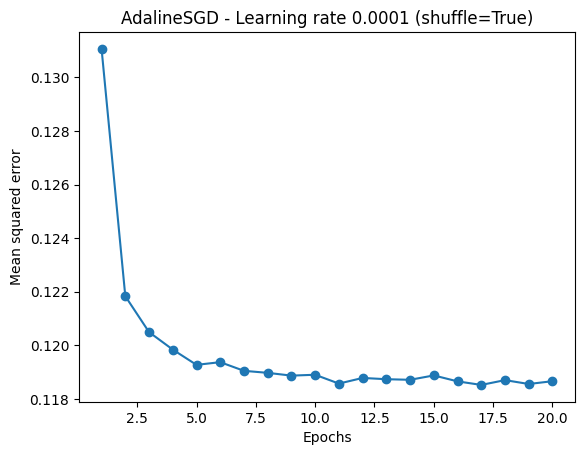

In [170]:
fig, ax = plt.subplots()
ada3 = AdalineSGD(n_iter=20, eta=0.0001, shuffle=True, random_state=1).fit(
    X_train.values, y_train.values
)
ax.plot(range(1, len(ada3.losses_) + 1), ada3.losses_, marker='o')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean squared error')
ax.set_title('AdalineSGD - Learning rate 0.0001 (shuffle=True)')
plt.show()

In [171]:
y_pred = ada3.predict(X_test.values)
print(f"AdalineSGD accuracy with n_iter 15 and eta 0.0001 (shuffle=True): {accuracy_score(y_test, y_pred):.4f}")

AdalineSGD accuracy with n_iter 15 and eta 0.0001 (shuffle=True): 0.8449


This excercise showed how AdalineSGD is better for these bigger data sets in terms of accuracy and reducing error. The trade off is that we need lower learning rates due to the model being trained on single points so it ultimately takes longer but the results will be better.

So we will test a new set of learning rates and keep shuffling on to find the most optimal model and accuracy while visualizing the learning process.

AdalineSGD accuracy with n_iter=5, eta=0.001: 0.8466
AdalineSGD accuracy with n_iter=5, eta=0.0001: 0.8390
AdalineSGD accuracy with n_iter=5, eta=1e-05: 0.8257
AdalineSGD accuracy with n_iter=10, eta=0.001: 0.8459
AdalineSGD accuracy with n_iter=10, eta=0.0001: 0.8401
AdalineSGD accuracy with n_iter=10, eta=1e-05: 0.8282
AdalineSGD accuracy with n_iter=15, eta=0.001: 0.8384
AdalineSGD accuracy with n_iter=15, eta=0.0001: 0.8424
AdalineSGD accuracy with n_iter=15, eta=1e-05: 0.8338
AdalineSGD accuracy with n_iter=20, eta=0.001: 0.8403
AdalineSGD accuracy with n_iter=20, eta=0.0001: 0.8449
AdalineSGD accuracy with n_iter=20, eta=1e-05: 0.8369
AdalineSGD accuracy with n_iter=30, eta=0.001: 0.8365
AdalineSGD accuracy with n_iter=30, eta=0.0001: 0.8367
AdalineSGD accuracy with n_iter=30, eta=1e-05: 0.8390


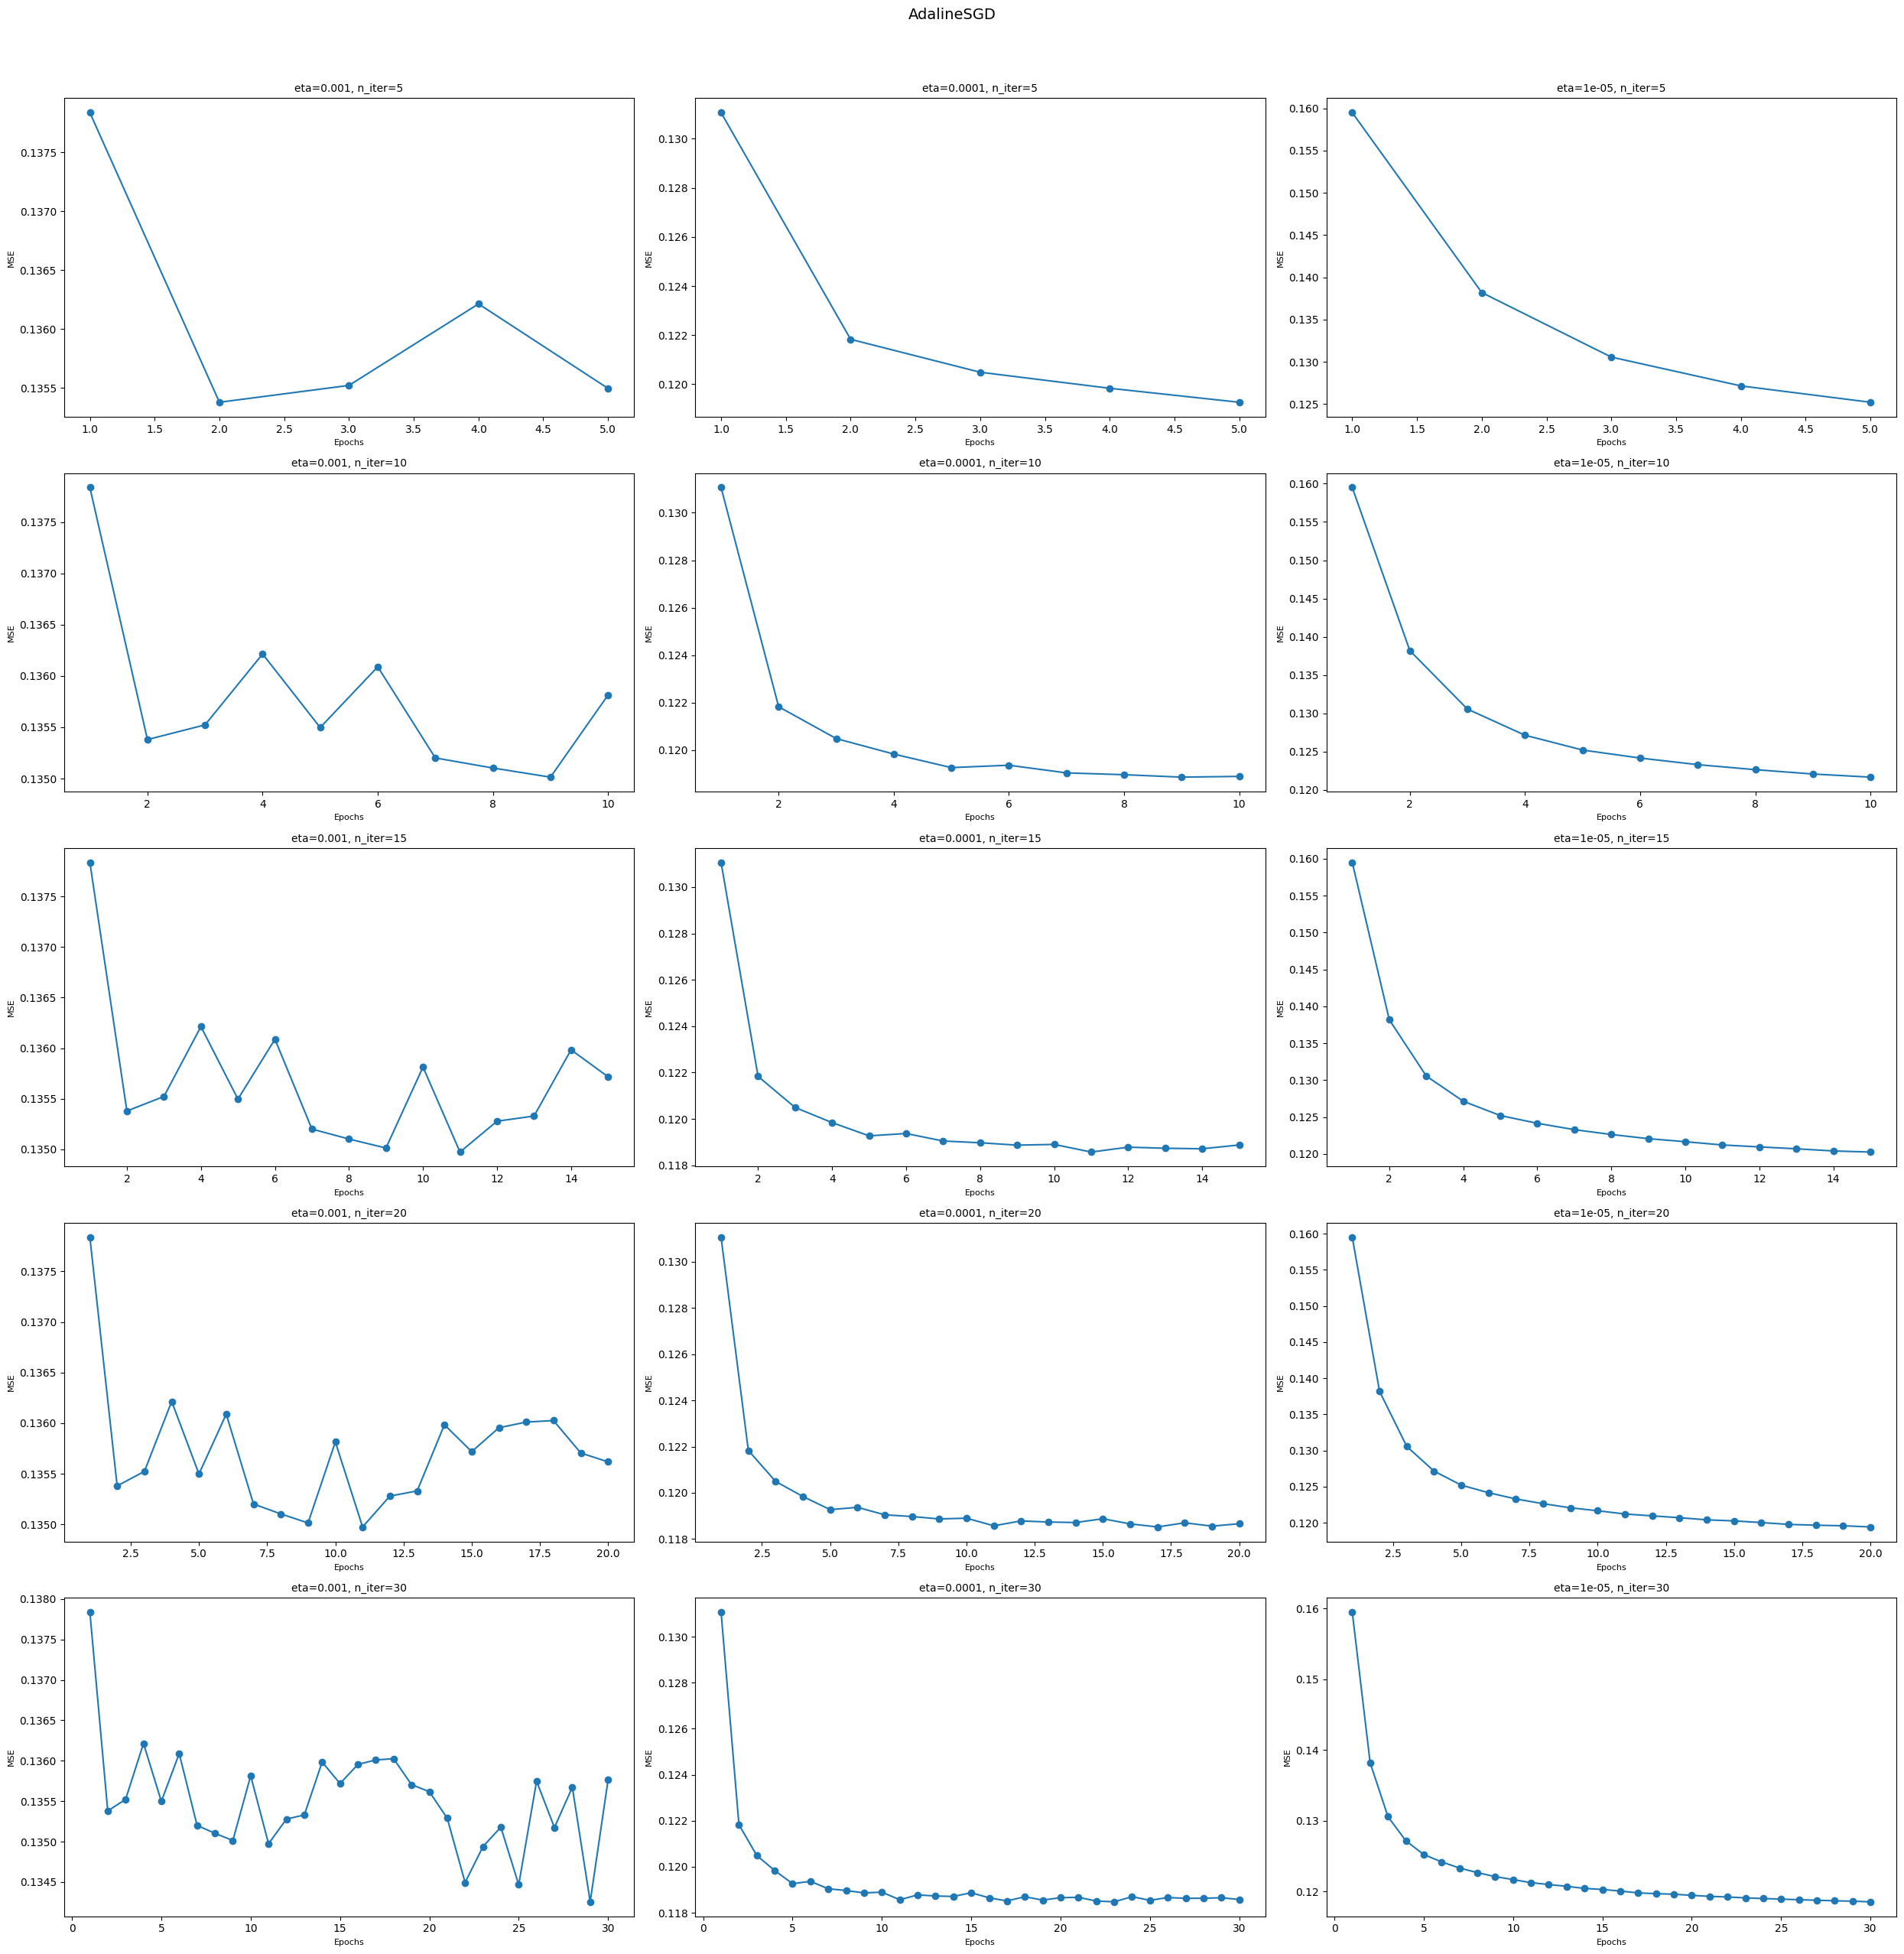

In [172]:
list_eta = [.001, 0.0001, .00001]
list_niter = [5, 10, 15, 20, 30]


fig, ax = plt.subplots(nrows=len(list_niter), ncols=len(list_eta), figsize=(25, 25))
fig.suptitle("AdalineSGD", fontsize=14, y=1.02)

for j, n_temp in enumerate(list_niter):
    for i, e_temp in enumerate(list_eta):
        ada = AdalineSGD(n_iter=n_temp, eta=e_temp, shuffle=True, random_state=1).fit(X_train.values, y_train.values)

        # Plot the loss fucnrtions
        ax[j, i].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=8)
        ax[j, i].set_ylabel('MSE', fontsize=8)
        ax[j, i].set_title(f"eta={e_temp}, n_iter={n_temp}", fontsize=10)

        # accuracies
        y_pred = ada.predict(X_test.values)
        acc = accuracy_score(y_test, y_pred)
        results.append({"eta": e_temp, "n_iter": n_temp, "accuracy": acc})
        print(f"AdalineSGD accuracy with n_iter={n_temp}, eta={e_temp}: {acc:.4f}")
        

plt.tight_layout()
plt.show()


Based of the accuracies we found that at 5 iterations and  learning rate of .001 we landed on the highest accuracy model, which was .8466. But we were concerned again about just getting lucky runs so we tested again on the different seeds and check the average.

In [173]:
# create empty result list and create parameters to test
results = []
seeds = [1, 2, 3, 4, 5]
list_eta = [0.001, 0.0001, 0.00001]
list_niter = [5, 10, 15, 20, 30]

# Test AdalineSGD Model with shuffling and random seeds
for seed in seeds:
    print(f"\nRandom State: {seed}")
    for n_temp in list_niter:
        for e_temp in list_eta:
            ada = AdalineSGD(n_iter=n_temp, eta=e_temp, shuffle=True, random_state=seed).fit(X_train.values, y_train.values)

            # accuracies
            y_pred = ada.predict(X_test.values)
            acc = accuracy_score(y_test, y_pred)
            results.append({"seed": seed, "eta": e_temp, "n_iter": n_temp, "accuracy": acc})
            print(f"eta={e_temp}, n_iter={n_temp} --> Test Accuracy: {acc:.4f}")


# CTurn results into datframe
df_results = pd.DataFrame(results)
# take the average across seeds for each (eta, n_iter)
avg_results = (df_results.groupby(["eta", "n_iter"])["accuracy"].mean().reset_index())
# Sort by accuracy
avg_results = avg_results.sort_values(by="accuracy", ascending=False)
# Print results
print("\nAverage accuracies across all seeds: \n")
print(avg_results.to_string(index=False))




Random State: 1
eta=0.001, n_iter=5 --> Test Accuracy: 0.8466
eta=0.0001, n_iter=5 --> Test Accuracy: 0.8390
eta=1e-05, n_iter=5 --> Test Accuracy: 0.8257
eta=0.001, n_iter=10 --> Test Accuracy: 0.8459
eta=0.0001, n_iter=10 --> Test Accuracy: 0.8401
eta=1e-05, n_iter=10 --> Test Accuracy: 0.8282
eta=0.001, n_iter=15 --> Test Accuracy: 0.8384
eta=0.0001, n_iter=15 --> Test Accuracy: 0.8424
eta=1e-05, n_iter=15 --> Test Accuracy: 0.8338
eta=0.001, n_iter=20 --> Test Accuracy: 0.8403
eta=0.0001, n_iter=20 --> Test Accuracy: 0.8449
eta=1e-05, n_iter=20 --> Test Accuracy: 0.8369
eta=0.001, n_iter=30 --> Test Accuracy: 0.8365
eta=0.0001, n_iter=30 --> Test Accuracy: 0.8367
eta=1e-05, n_iter=30 --> Test Accuracy: 0.8390

Random State: 2
eta=0.001, n_iter=5 --> Test Accuracy: 0.7447
eta=0.0001, n_iter=5 --> Test Accuracy: 0.8405
eta=1e-05, n_iter=5 --> Test Accuracy: 0.8269
eta=0.001, n_iter=10 --> Test Accuracy: 0.8363
eta=0.0001, n_iter=10 --> Test Accuracy: 0.8464
eta=1e-05, n_iter=10 --> 

These results show us that as we suspected as the random state seeds change we get varying accuracies. What we found that was the eta of .0001 and the iterations at 15 lead to an average of .8418. This was very suprising to us as the AdalineSGD model from scikit only had a .8073 accuracy. We decided that this could have been could parameter tuning by us and since it consistently had a higher accuracy. So we decided to use this model as our validation output. We will use the highest accuracy seed so we will use seed 3 and eta: .0001 and n_iter: 15, which had an accuracy of .8457.

In [197]:
# Train manual AdalineSGD with chosen best parameters
ada_best = AdalineSGD(n_iter=15,eta=0.0001,shuffle=True,random_state=3).fit(X_train.values, y_train.values)
# Predict on validation set
val_preds_manual_ada = ada_best.predict(X_validation.values)

# Save predictions to CSV
pd.DataFrame(val_preds_manual_ada).to_csv("Group_9_Adaline_PredictedOutputs.csv",index=False,header=False)


# Logistic Regression

## Baseline Logistic Regression Model

In [175]:
logReg = LogisticRegression(random_state=17)
logReg.fit(X_train, y_train)
y_pred_lr = logReg.predict(X_test)
print(f"Logistic Regression accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")

Logistic Regression accuracy: 0.8534


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Tuning Hyperparameters

In [176]:
# creates a pipeline to chain together multiple processing steps and a final estimator to streamline ML workflow
# The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
# Define the hyperparameter grid for tuning
param_grid = {
    'C': np.logspace(-4,4,20)
}

# Create and fit the GridSearchCV object
# This will perform an exhaustive search over the parameter grid
# using 5-fold cross-validation.
grid_search_log = GridSearchCV(
    estimator = LogisticRegression(solver = 'lbfgs', random_state = 17, max_iter=500),
    param_grid = param_grid,
    cv=5,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 1)
grid_search_log.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500, random_state=17),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])},
             scoring='accuracy', verbose=1)

In [177]:
def plot_best_decision_boundary(bestModel, X, y):
    best_model = bestModel.best_estimator_
    best_params = bestModel.best_params_
    best_kernel = best_params.get('kernel', 'linear') # Default to linear if not found

    # Standardize the y input and encode if necessary
    y_series = pd.Series(y.values.ravel())

    features = X[['education-num','fnlwgt']]

    fig, axes = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)

    ax = axes
    # Select the two features for the current plot
    f1_name = features.columns[0]
    f2_name = features.columns[1]

    # Use the best model from GridSearchCV
    model = best_model

    # Since the best model was trained on the full dataset, we'll retrain
    # a new instance of it on just the two features for plotting purposes.
    # This is the most reliable way to ensure the decision boundary is correct.
    plot_model = bestModel
    if best_kernel == 'poly':
        plot_model.degree = best_params.get('degree', 3) # Handle poly degree separately
    plot_model.fit(features.values, y_series)

    # Plot the data points
    ax.scatter(features.iloc[:, 0], features.iloc[:, 1], c=y_series, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

    # Create and plot the decision boundary
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                                np.linspace(ylim[0], ylim[1], 500))
    Z = plot_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    try:
      # Highlight the support vectors
      ax.scatter(plot_model.support_vectors_[:, 0], plot_model.support_vectors_[:, 1], s=100,
                        linewidth=1, facecolors='none', edgecolors='k')
    except:
      pass
    # Set titles and labels
    ax.set_title(f"({f1_name} vs {f2_name})", fontsize = 8)
    ax.set_xlabel(f1_name)
    ax.set_ylabel(f2_name)
    ax.set_aspect('equal', adjustable='box')
    # Format best_params into a readable string
    param_str = "\n".join([f"{key}: {value}" for key, value in best_params.items()])

    plt.suptitle(f"GridSearchCV Best Model Decision Boundary\nBest Parameters:\n{param_str}", fontsize=8, y=1.05)

    plt.show()
def plot_confusion_matrix(cm, y_true):
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))

    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [178]:
# Get the best estimator and make predictions
print(f"Best parameters found: {grid_search_log.best_params_}")

# Use the best model found by the grid search for predictions
y_pred = grid_search_log.best_estimator_.predict(X_test)

# Calculate and print the model's accuracy
accuracy_log = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy on Test Data: {accuracy_log:.4f}")
precision_score_log = precision_score(y_test, y_pred)
print(f"Precision Score: {precision_score_log:.4f}")
recall_score_log = recall_score(y_test, y_pred)
print(f"Recall Score: {recall_score_log:.4f}")

Best parameters found: {'C': 3792.690190732246}

Model Accuracy on Test Data: 0.8511
Precision Score: 0.7328
Recall Score: 0.6129


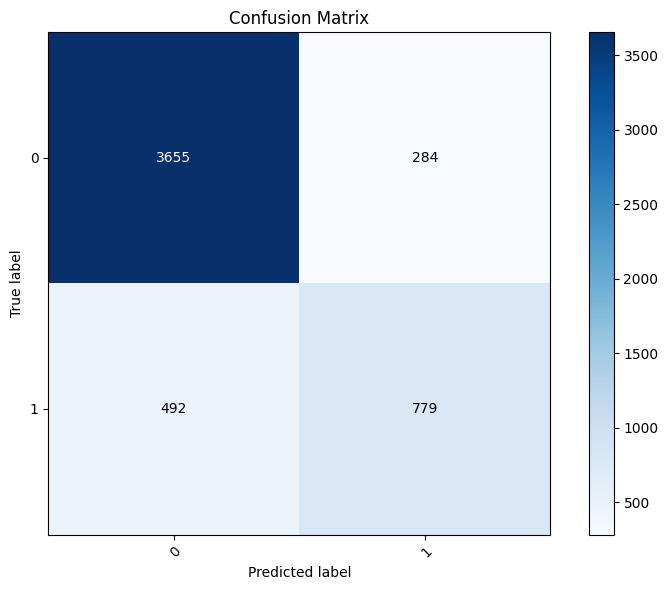

In [179]:
# Plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, y_test)

In [180]:
# Predictions for logreg
valid_pred_lr = pd.DataFrame(grid_search_log.predict(X_validation))
valid_pred_lr.to_csv('Group_9_LogisticRegression_PredictedOutputs.csv', index=False)

In [181]:
X_validation

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,-0.851191,-0.277853,10,-0.147225,-0.211274,-0.212164,0.0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.469374,-1.304090,9,-0.147225,-0.211274,-0.051009,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.704461,-0.036955,13,-0.147225,-0.211274,1.157652,0.0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.631097,0.001731,13,-0.147225,-0.211274,-0.051009,0.0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.704461,-0.004766,10,0.128973,-0.211274,0.754765,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,2.376858,0.747626,13,0.144902,-0.211274,-1.984865,0.0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6509,1.203022,0.591777,10,-0.147225,-0.211274,-0.051009,0.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6510,0.616104,1.538198,15,12.395693,-0.211274,0.593610,0.0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6511,-0.851191,-1.368832,13,-0.147225,-0.211274,-0.051009,0.0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# SVM

## Baseline SVM Model

In [182]:
svm = SVC(random_state=17)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print(f"SVM accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")


SVM accuracy: 0.8543


## Tuning SVM Model

In [183]:
# creates a pipeline to chain together multiple processing steps and a final estimator to streamline ML workflow
# The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
# Define the hyperparameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Create and fit the GridSearchCV object
# This will perform an exhaustive search over the parameter grid
# using 5-fold cross-validation.
grid_search_svm = GridSearchCV(
    estimator = SVC(random_state=17),
    param_grid = param_grid,
    cv=5,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 1)
grid_search_svm.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=SVC(random_state=17), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=1)

In [184]:
best_model = SVC(C = 10, kernel = 'rbf', random_state=17)
best_model.fit(X_train, y_train)
y_pred_svm = best_model.predict(X_test)
# Get the best estimator and make predictions
#print(f"Best parameters found: {grid_search_svm.best_params_}")

# Use the best model found by the grid search for predictions
y_pred = best_model.predict(X_test)

# Calculate and print the model's accuracy
accuracy_svm = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy on Test Data: {accuracy_svm:.4f}")
precision_score_svm = precision_score(y_test, y_pred)
print(f"Precision Score: {precision_score_svm:.4f}")
recall_score_svm = recall_score(y_test, y_pred)
print(f"Recall Score: {recall_score_svm:.4f}")


Model Accuracy on Test Data: 0.8551
Precision Score: 0.7676
Recall Score: 0.5822


In [185]:
def plot_best_decision_boundary_svm(X, y):
    best_model = SVC(C = 10, kernel = 'rbf', random_state=17)
    best_params = {'C': np.float64(10), 'Kernel': 'RBF'}
    best_kernel = best_params.get('kernel', 'linear') # Default to linear if not found

    # Standardize the y input and encode if necessary
    y_series = pd.Series(y.values.ravel())

    features = X[['education-num','fnlwgt']]

    fig, axes = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)

    ax = axes
    # Select the two features for the current plot
    f1_name = features.columns[0]
    f2_name = features.columns[1]

    # Use the best model from GridSearchCV
    model = best_model

    # Since the best model was trained on the full dataset, we'll retrain
    # a new instance of it on just the two features for plotting purposes.
    # This is the most reliable way to ensure the decision boundary is correct.
    plot_model = best_model
    if best_kernel == 'poly':
        plot_model.degree = best_params.get('degree', 3) # Handle poly degree separately
    plot_model.fit(features.values, y_series)

    # Plot the data points
    ax.scatter(features.iloc[:, 0], features.iloc[:, 1], c=y_series, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

    # Create and plot the decision boundary
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                                np.linspace(ylim[0], ylim[1], 500))
    Z = plot_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    try:
      # Highlight the support vectors
      ax.scatter(plot_model.support_vectors_[:, 0], plot_model.support_vectors_[:, 1], s=100,
                        linewidth=1, facecolors='none', edgecolors='k')
    except:
      pass
    # Set titles and labels
    ax.set_title(f"({f1_name} vs {f2_name})", fontsize = 8)
    ax.set_xlabel(f1_name)
    ax.set_ylabel(f2_name)
    ax.set_aspect('equal', adjustable='box')
    # Format best_params into a readable string
    param_str = "\n".join([f"{key}: {value}" for key, value in best_params.items()])

    plt.suptitle(f"GridSearchCV Best Model Decision Boundary\nBest Parameters:\n{param_str}", fontsize=8, y=1.05)

    plt.show()

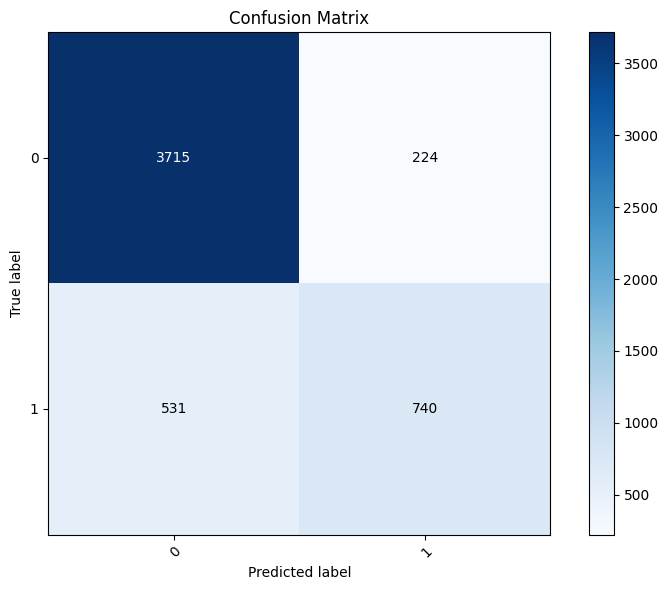

In [186]:
# Plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, y_test)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


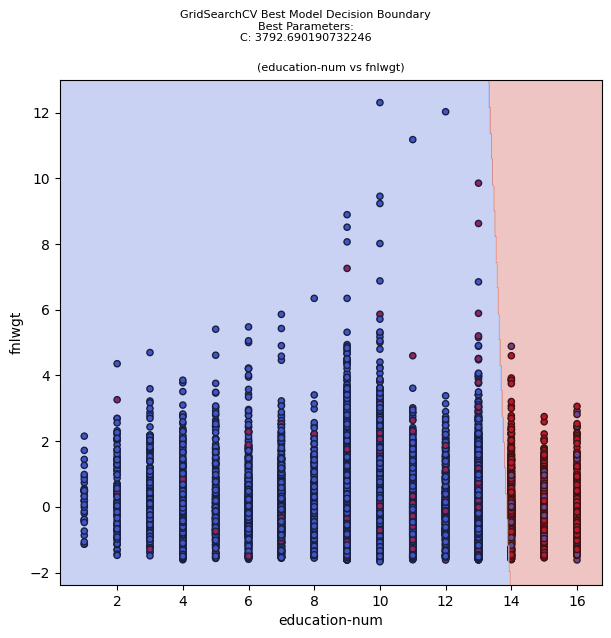

None


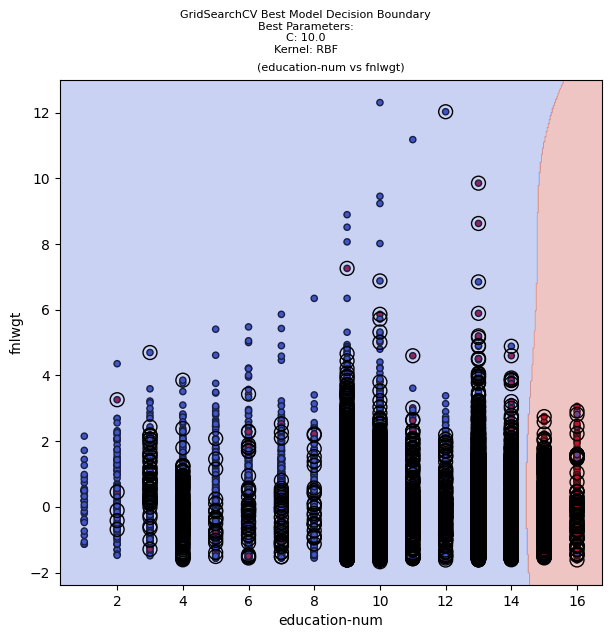

None


In [187]:
# Plotting Decision boundry between two points
print(plot_best_decision_boundary(grid_search_log, X_train, y_train))
print(plot_best_decision_boundary_svm(X_train, y_train))

In [188]:
# Predictions for svm
valid_pred_svm = pd.DataFrame(best_model.predict(X_validation))
valid_pred_svm.to_csv('Group_9_SVM_PredictedOutputs.csv', index=False)

In [189]:
# ### Training the perceptron model
ppn = Perceptron(eta=0.1, n_iter=10, random_state=1)
ppn.fit(X_train, y_train)

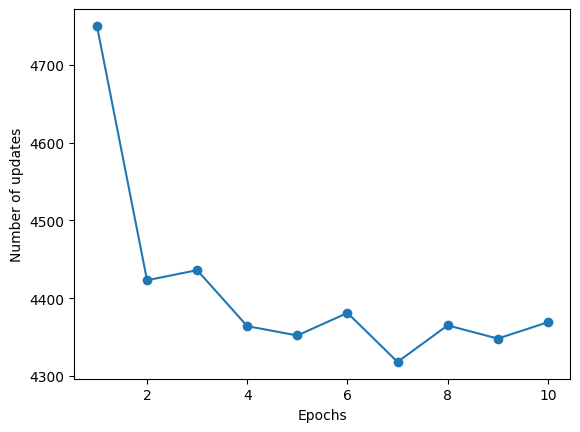

In [190]:
# Plot miscalssificaiotn error for each epoch
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

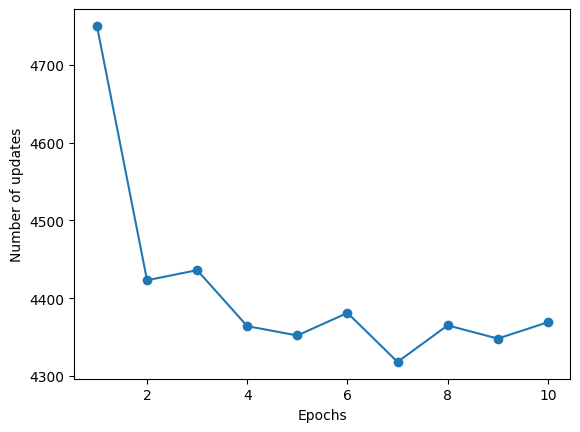

In [191]:
# Plot miscalssificaiotn error for each epoch
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

In [192]:
# ### Training the perceptron model
ppn = Perceptron(eta=0.1, n_iter=10, random_state=1)
ppn.fit(X, y)

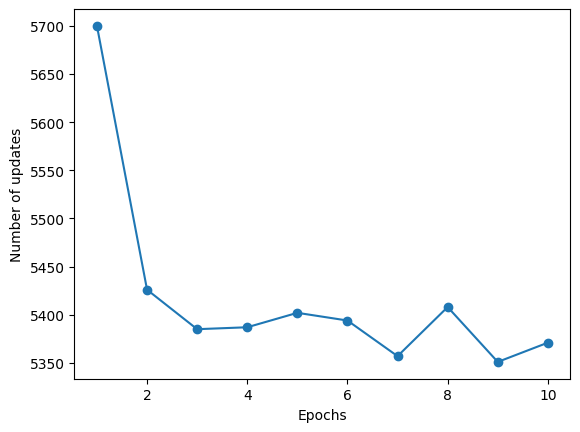

In [193]:
# Plot miscalssificaiotn error for each epoch
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()


#Reflection and Conceptual Questions


##a. Why is feature scaling important for gradient-based algorithms?
Feature scaling is important because it prevents features with a higher scale from having more impact in the gradient descent algorithm. When features with large scales dominate the algorithm, often unequal steps can be taken disproportionately along dimensions with large-scale features, creating a zigzag pattern and artifically making the features with a higher scale have more importance and thus making the algorithm take longer to converge. Choosing a learning rate is also difficult since a large rate may cause divergence for large features and a small learning rate may cause an impossibly slow convergence to the global minimum

##b. Explain the difference between batch gradient descent and stochastic gradient descent.
Batch gradient descent is where the adaline model updates the weights after going through the entire training dataset. It does this by taking a step in the opposite direction of the loss gradient that is calculated from the whole training dataset. With these updates being all at one time on the parameters it is very computationally difficult. It can be very inefficent with datasets that are extremely large. Stochastic gradient descent is useful because it trains incrementally on the training data after each example, this makes it computationally more efficeint than batch gradient descent because of its updates being ran on less data. This allows it to be very useful for when you constantly have new data coming in and want to continously update the model to account for new training data.


##c. Why does scikit-learn Perceptron and Adline algorithms outperform book code? i. Research and develop an informed answer.
The scikit-lean Perceptron and Adline algorithms outperform the the book code due to it being the most optimized and improved version of the book code. The scikit-learn has pre packaged ways to make the data the most optimal when it comes to shuffling, preprocessing, feature scaling, etc. THe book code allows you to try to these different ways but there is so many variations of feature scaling and optimizing parameters that it would take way too long to find the most optimal combination. The scikit-learn runs through all of these various combinations and optimizations to come up with the best and most stable model that would be very difficult to get with the book's model. It can also implement these models with a lower computational cost compared to the book's code in most scenarios.


##d. Compare the decision boundaries of logistic regression and SVM.
The decision boundaries of a logistic regression model versus a SVM differ in a few different ways. The logistic regression decision boundary is a linear boundary only. It take the values that you are trying to predict and converts it to a value of 0 or 1. And it decides whether a value is yes or no. It uses the sigmoid function to map the probabilities. It uses probabilties to decide on how likeley a category would fit into a yes or no decision. So the decision boundary ultimately is a threshold linear boundary where anything above 50% likely would fall on either side of the boundary predicting the corresponding value. The SVM decision boundary is about optimizing the margins in between the hyperplanes. It is about making the maximum margin in between the hyperplanes. This makes it better for dealing with outliers because of the harder margins, but it eliminates the probability based predictions that logistic regression has because it is a strict yes/no.


##e. What is the role of regularization in preventing overfitting?
Penalizes model complexity: Discourages large coefficient weights Limits excessive or unneeded parameters

Promotes simplicity

Improves generalization of unseen data

Enables feature selection

Lasso Regression: Shrinks irrelevant coefficients to zero

Ridge Regression: Shrinks coefficients to zero, but never fully eliminates them


##f. Vary the C values of the scikit-learn LogisticRegression and linear SVC models with [0.01, 1.0, 100.0]. Discuss the impact

In [194]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

print("Logistic Regression:\n")
C_values = [0.01, 1, 100]
dataLog = pd.DataFrame(columns=['C', 'F1 Score', 'Accuracy', 'Recall', 'Precision'])
dataSVM = pd.DataFrame(columns=['C', 'F1 Score', 'Accuracy', 'Recall', 'Precision'])

# Logistic Regression
for i in C_values:
    tempModel = LogisticRegression(C=i, solver='lbfgs', random_state=17, max_iter=1000)
    tempModel.fit(X_train, y_train)
    y_pred_temp = tempModel.predict(X_test)
    confMatrix = confusion_matrix(y_test, y_pred_temp)
    accuracy = accuracy_score(y_test, y_pred_temp)
    f1 = f1_score(y_test, y_pred_temp)
    recall = recall_score(y_test, y_pred_temp)
    precision = precision_score(y_test, y_pred_temp)
    print(f"\nResults for C = {i}")
    print("Confusion Matrix:")
    print(pd.DataFrame(confMatrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print(f"Accuracy: {accuracy:.4f}\n")
    dataLog = pd.concat([dataLog, pd.DataFrame({'C':[i], 'F1 Score':[f1], 'Accuracy':[accuracy], 'Recall':[recall], 'Precision':[precision]})], ignore_index=True)

# SVM
print("\nSVM:\n")
for i in C_values:
    tempModel = SVC(C=i, kernel='linear', random_state=17)
    tempModel.fit(X_train, y_train)
    y_pred_temp = tempModel.predict(X_test)
    confMatrix = confusion_matrix(y_test, y_pred_temp)
    accuracy = accuracy_score(y_test, y_pred_temp)
    f1 = f1_score(y_test, y_pred_temp)
    recall = recall_score(y_test, y_pred_temp)
    precision = precision_score(y_test, y_pred_temp)
    print(f"\nResults for C = {i}")
    print("Confusion Matrix:")
    print(pd.DataFrame(confMatrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print(f"Accuracy: {accuracy:.4f}\n")
    dataSVM = pd.concat([dataSVM, pd.DataFrame({'C':[i], 'F1 Score':[f1], 'Accuracy':[accuracy], 'Recall':[recall], 'Precision':[precision]})], ignore_index=True)


Logistic Regression:


Results for C = 0.01
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         3691          248
Actual 1          558          713
Accuracy: 0.8453



/var/folders/_y/r2dpgnhs1h38x5_cq27b9xlw0000gn/T/ipykernel_51281/2929363694.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataLog = pd.concat([dataLog, pd.DataFrame({'C':[i], 'F1 Score':[f1], 'Accuracy':[accuracy], 'Recall':[recall], 'Precision':[precision]})], ignore_index=True)



Results for C = 1
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         3658          281
Actual 1          493          778
Accuracy: 0.8514


Results for C = 100
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         3658          281
Actual 1          493          778
Accuracy: 0.8514


SVM:


Results for C = 0.01
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         3698          241
Actual 1          527          744
Accuracy: 0.8526



/var/folders/_y/r2dpgnhs1h38x5_cq27b9xlw0000gn/T/ipykernel_51281/2929363694.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataSVM = pd.concat([dataSVM, pd.DataFrame({'C':[i], 'F1 Score':[f1], 'Accuracy':[accuracy], 'Recall':[recall], 'Precision':[precision]})], ignore_index=True)



Results for C = 1
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         3657          282
Actual 1          490          781
Accuracy: 0.8518


Results for C = 100
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         3658          281
Actual 1          494          777
Accuracy: 0.8512



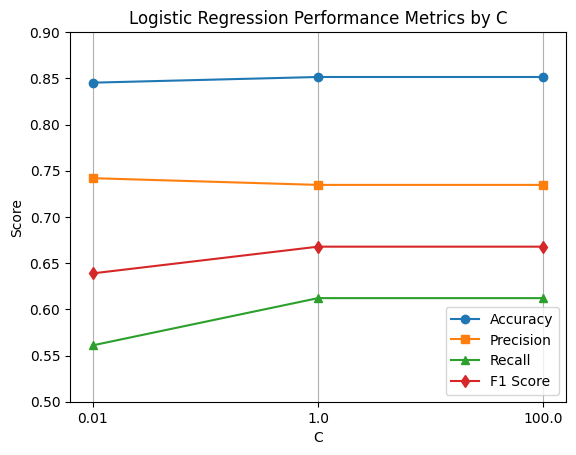

In [195]:
plt.plot(dataLog['C'].astype(str), dataLog['Accuracy'], marker='o', label='Accuracy')
plt.plot(dataLog['C'].astype(str), dataLog['Precision'], marker='s', label='Precision')
plt.plot(dataLog['C'].astype(str), dataLog['Recall'], marker='^', label='Recall')
plt.plot(dataLog['C'].astype(str), dataLog['F1 Score'], marker='d', label='F1 Score')

plt.xlabel('C')
plt.ylabel('Score')
plt.title('Logistic Regression Performance Metrics by C')
plt.ylim(.5, 0.9)
plt.legend()
plt.grid(axis='x')
plt.show()


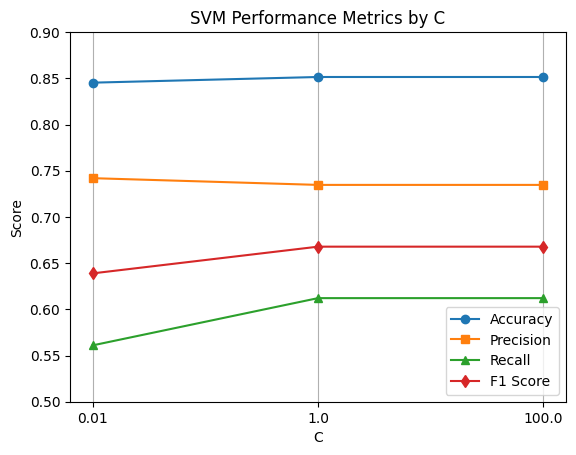

In [196]:
plt.plot(dataSVM['C'].astype(str), dataLog['Accuracy'], marker='o', label='Accuracy')
plt.plot(dataSVM['C'].astype(str), dataLog['Precision'], marker='s', label='Precision')
plt.plot(dataSVM['C'].astype(str), dataLog['Recall'], marker='^', label='Recall')
plt.plot(dataSVM['C'].astype(str), dataLog['F1 Score'], marker='d', label='F1 Score')

plt.xlabel('C')
plt.ylabel('Score')
plt.title('SVM Performance Metrics by C')
plt.ylim(.5, 0.9)
plt.legend()
plt.grid(axis='x')
plt.show()
